⬇️ Downloading CIC-IoT-2023 dataset via kagglehub...
Using Colab cache for faster access to the 'cic-iot-2023' dataset.
✅ Dataset downloaded to: /kaggle/input/cic-iot-2023
📂 Found 169 CSV files in the dataset.
📊 Train files: 135, Val files: 34

🚀 Starting batch-wise training...

--- Batch 1 | Files: 2 ---
🌲 Training RandomForest with total trees = 1
🔍 Validation sample from: part-00105-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
✅ Batch 1 | Trees: 1 | Train Acc: 0.9230 | Val Acc: 0.9198 | Val F1: 0.9172

--- Batch 2 | Files: 2 ---
🌲 Training RandomForest with total trees = 2
🔍 Validation sample from: part-00109-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
✅ Batch 2 | Trees: 2 | Train Acc: 0.9540 | Val Acc: 0.9515 | Val F1: 0.9507

--- Batch 3 | Files: 2 ---
🌲 Training RandomForest with total trees = 3
🔍 Validation sample from: part-00045-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv
✅ Batch 3 | Trees: 3 | Train Acc: 0.9426 | Val Acc: 0.9438 | Val F1: 0.9422

--- Batch 4 | Files: 2 -

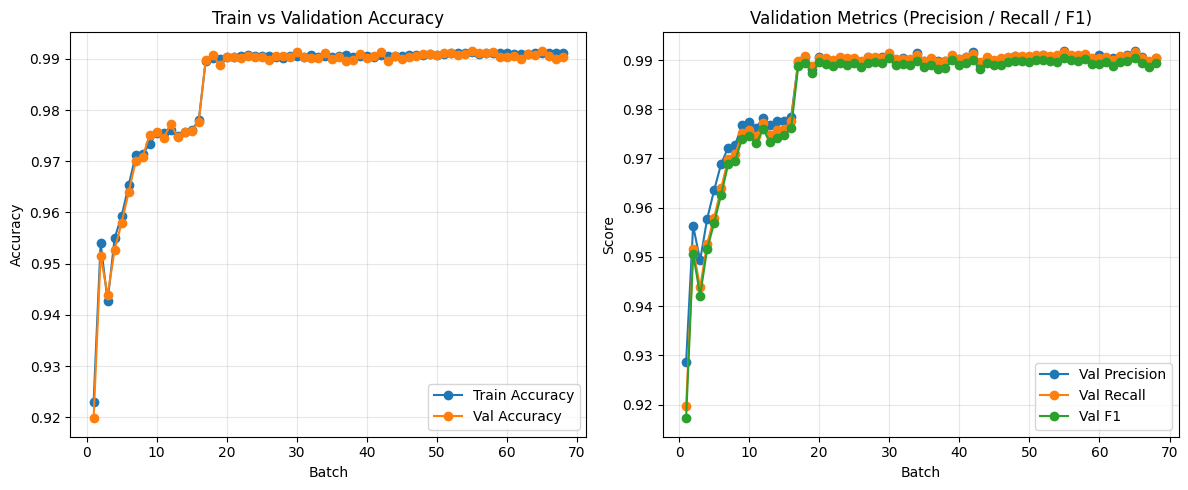

In [ ]:
import os
import gc
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import kagglehub

# ==========================================================
# CONFIG
# ==========================================================
BATCH_SIZE_FILES = 2        # how many CSV files to process at once
TREES_PER_BATCH = 1         # how many trees to add per batch
MAX_TREES       = 100       # upper cap on total trees (to limit RAM)
VAL_SAMPLE_RATE = 0.10      # fraction of rows from a val file (e.g. 10%)
RANDOM_STATE    = 42

# label column name candidates in CIC-IoT-2023
LABEL_CANDIDATES = ['label', 'Label', 'class', 'Class']

# optional: columns to drop if present (IPs, ports, timestamps etc.)
DROP_COLS = [
    'uid', 'timestamp', 'flow_id', 'source_ip', 'source_port',
    'destination_ip', 'destination_port', 'src_ip', 'dst_ip',
    'src_port', 'dst_port'
]

# ==========================================================
# 1. DOWNLOAD DATASET
# ==========================================================
print("⬇️ Downloading CIC-IoT-2023 dataset via kagglehub...")
dataset_dir = kagglehub.dataset_download("akashdogra/cic-iot-2023")
print(f"✅ Dataset downloaded to: {dataset_dir}")

# ==========================================================
# 2. DISCOVER CSV FILES
# ==========================================================
csv_files = []
for root, dirs, files in os.walk(dataset_dir):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, f))

csv_files = sorted(csv_files)
print(f"📂 Found {len(csv_files)} CSV files in the dataset.")

if len(csv_files) == 0:
    raise RuntimeError("No CSV files found. Check dataset_dir structure.")

# ==========================================================
# 3. TRAIN / VALIDATION SPLIT AT FILE LEVEL (80/20)
# ==========================================================
train_files, val_files = train_test_split(
    csv_files, test_size=0.2, random_state=RANDOM_STATE
)
print(f"📊 Train files: {len(train_files)}, Val files: {len(val_files)}")

# ==========================================================
# 4. HELPER: PREPROCESS A DATAFRAME
# ==========================================================
label_encoder = LabelEncoder()
encoder_fitted = False

def find_label_column(df):
    for col in LABEL_CANDIDATES:
        if col in df.columns:
            return col
    return None

def preprocess_df(df, fit_encoder=False):
    """
    - find label column
    - drop useless columns
    - handle NaNs
    - encode labels
    - return X (np.array) and y (np.array)
    """
    global encoder_fitted, label_encoder

    target_col = find_label_column(df)
    if target_col is None:
        raise ValueError("Could not find label column in dataframe.")

    # drop known non-feature columns if present
    to_drop = [c for c in DROP_COLS if c in df.columns]
    if to_drop:
        df = df.drop(columns=to_drop)

    # simple fill NaNs with 0
    df = df.fillna(0)

    # separate X, y
    y = df[target_col].astype(str)
    X = df.drop(columns=[target_col])

    # ensure numeric features (non-numeric cols -> drop or encode if needed)
    # simplest: keep only numeric
    X = X.select_dtypes(include=[np.number])

    # fit label encoder on first batch
    if fit_encoder and not encoder_fitted:
        label_encoder.fit(y.unique())
        encoder_fitted = True

    if not encoder_fitted:
        raise RuntimeError("LabelEncoder not fitted yet but needed.")

    # keep only rows whose label is known to the encoder
    known = np.isin(y, label_encoder.classes_)
    X = X[known]
    y = y[known]

    y_enc = label_encoder.transform(y)

    return X.values, y_enc

# ==========================================================
# 5. INITIALIZE RANDOM FOREST (WARM START)
# ==========================================================
rf = RandomForestClassifier(
    n_estimators=0,     # will grow incrementally
    warm_start=True,    # keep existing trees, add more each batch
    n_jobs=-1,          # use all cores in Colab
    random_state=RANDOM_STATE,
    max_depth=15        # limit depth to control memory
)

# ==========================================================
# 6. TRAINING LOOP OVER FILE-BATCHES
# ==========================================================
history = {
    "batch": [],
    "n_trees": [],
    "train_acc": [],
    "val_acc": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1": []
}

print("\n🚀 Starting batch-wise training...")

batch_id = 0
for start in range(0, len(train_files), BATCH_SIZE_FILES):
    batch_id += 1
    batch_files = train_files[start : start + BATCH_SIZE_FILES]
    print(f"\n--- Batch {batch_id} | Files: {len(batch_files)} ---")

    # ----------------------------
    # Load & concat batch files
    # ----------------------------
    dfs = []
    for path in batch_files:
        try:
            df_part = pd.read_csv(path)
            dfs.append(df_part)
        except Exception as e:
            print(f"⚠️ Skipping file {path}: {e}")

    if not dfs:
        print("No valid files in this batch, skipping.")
        continue

    batch_df = pd.concat(dfs, ignore_index=True)
    del dfs
    gc.collect()

    # ----------------------------
    # Preprocess and get X, y
    # ----------------------------
    X_train, y_train = preprocess_df(batch_df, fit_encoder=(batch_id == 1))
    del batch_df
    gc.collect()

    if X_train.shape[0] == 0:
        print("⚠️ No usable rows after preprocessing in this batch, skipping.")
        continue

    # ----------------------------
    # Grow forest with new trees
    # ----------------------------
    if rf.n_estimators >= MAX_TREES:
        print("🛑 Reached MAX_TREES limit, stopping further training.")
        break

    rf.n_estimators += TREES_PER_BATCH
    print(f"🌲 Training RandomForest with total trees = {rf.n_estimators}")
    rf.fit(X_train, y_train)

    # ----------------------------
    # TRAIN METRICS ON THIS BATCH
    # ----------------------------
    y_train_pred = rf.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    # ----------------------------
    # VALIDATION ON A RANDOM VAL FILE (SAMPLED)
    # ----------------------------
    val_file = np.random.choice(val_files)
    print(f"🔍 Validation sample from: {os.path.basename(val_file)}")

    df_val = pd.read_csv(val_file)

    # subsample to control RAM / time
    if len(df_val) > 10000:
        df_val = df_val.sample(frac=VAL_SAMPLE_RATE, random_state=RANDOM_STATE)

    X_val, y_val = preprocess_df(df_val, fit_encoder=False)
    del df_val
    gc.collect()

    y_val_pred = rf.predict(X_val)

    val_acc = accuracy_score(y_val, y_val_pred)
    val_prec = precision_score(y_val, y_val_pred, average="weighted", zero_division=0)
    val_rec  = recall_score(y_val, y_val_pred, average="weighted", zero_division=0)
    val_f1   = f1_score(y_val, y_val_pred, average="weighted", zero_division=0)

    # ----------------------------
    # STORE HISTORY
    # ----------------------------
    history["batch"].append(batch_id)
    history["n_trees"].append(rf.n_estimators)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_precision"].append(val_prec)
    history["val_recall"].append(val_rec)
    history["val_f1"].append(val_f1)

    print(
        f"✅ Batch {batch_id} | Trees: {rf.n_estimators} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
        f"Val F1: {val_f1:.4f}"
    )

    # free batch arrays
    del X_train, y_train, X_val, y_val, y_train_pred, y_val_pred
    gc.collect()

print("\n🎉 Training loop finished.")

# ==========================================================
# 7. PLOT TRAIN vs VAL ACCURACY & OTHER METRICS
# ==========================================================
if len(history["batch"]) > 0:
    batches = history["batch"]

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(batches, history["train_acc"], marker="o", label="Train Accuracy")
    plt.plot(batches, history["val_acc"], marker="o", label="Val Accuracy")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Metrics plot
    plt.subplot(1, 2, 2)
    plt.plot(batches, history["val_precision"], marker="o", label="Val Precision")
    plt.plot(batches, history["val_recall"],    marker="o", label="Val Recall")
    plt.plot(batches, history["val_f1"],        marker="o", label="Val F1")
    plt.xlabel("Batch")
    plt.ylabel("Score")
    plt.title("Validation Metrics (Precision / Recall / F1)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No training history to plot (no successful batches).")


Using Colab cache for faster access to the 'cic-iot-2023' dataset.
CSV files found: 169
train:101, val:34, test:34
Starting batchwise training...
Batch 1 Trees:2 | Train:0.9864 Val:0.9832 Test:0.9823 | ValF1:0.9826 TestF1:0.9816
Batch 2 Trees:4 | Train:0.9852 Val:0.9839 Test:0.9837 | ValF1:0.9828 TestF1:0.9827
Batch 3 Trees:6 | Train:0.9881 Val:0.9871 Test:0.9877 | ValF1:0.9859 TestF1:0.9867
Batch 4 Trees:8 | Train:0.9893 Val:0.9886 Test:0.9890 | ValF1:0.9874 TestF1:0.9877
Batch 5 Trees:10 | Train:0.9892 Val:0.9883 Test:0.9890 | ValF1:0.9872 TestF1:0.9880
Batch 6 Trees:12 | Train:0.9890 Val:0.9885 Test:0.9887 | ValF1:0.9874 TestF1:0.9878
Batch 7 Trees:14 | Train:0.9900 Val:0.9895 Test:0.9898 | ValF1:0.9885 TestF1:0.9888
Batch 8 Trees:16 | Train:0.9897 Val:0.9896 Test:0.9896 | ValF1:0.9884 TestF1:0.9884
Batch 9 Trees:18 | Train:0.9897 Val:0.9903 Test:0.9898 | ValF1:0.9891 TestF1:0.9887
Batch 10 Trees:20 | Train:0.9900 Val:0.9899 Test:0.9901 | ValF1:0.9888 TestF1:0.9891
Batch 11 Trees:22

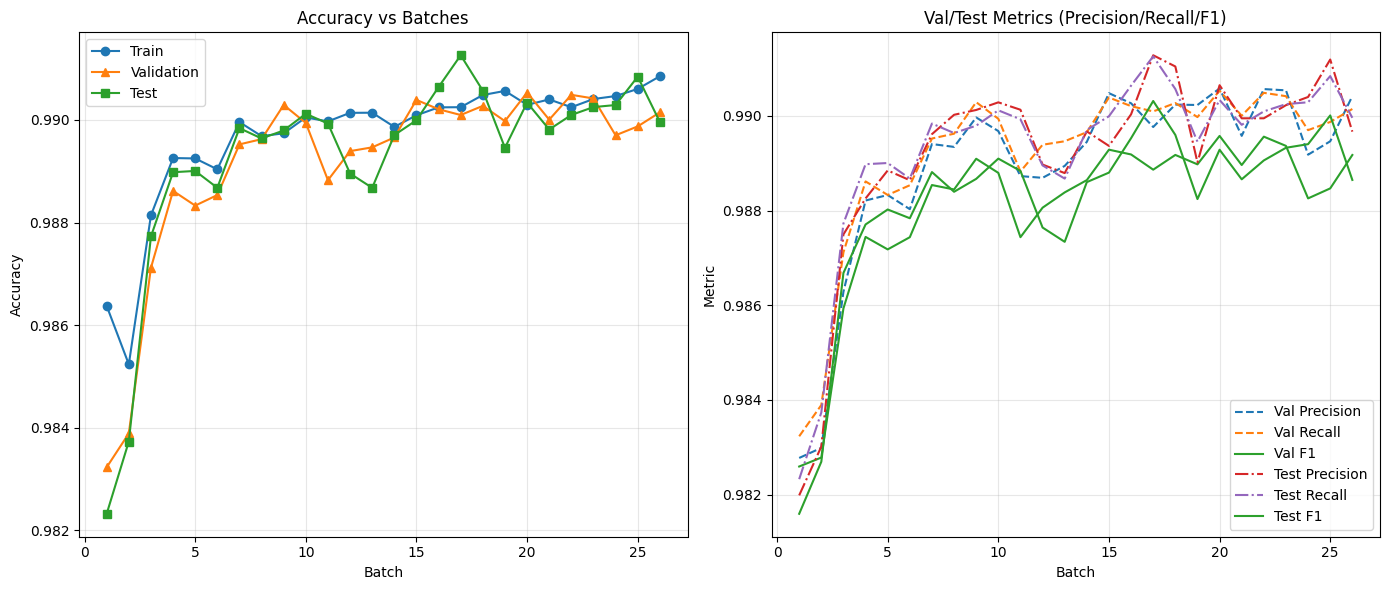

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import kagglehub

# --- CONFIG ---
BATCH_SIZE = 4       # Num CSV files loaded per batch (reduce if RAM errors)
TREES_PER_BATCH = 2    # Trees grown each batch
MAX_TREES = 200
VAL_SAMPLE_FRAC = 0.10 # Fraction of lines loaded from val/test file to save RAM
RANDOM_STATE = 42

# --- Download & Read File List ---
dataset_dir = kagglehub.dataset_download("akashdogra/cic-iot-2023")
csv_files = [
    os.path.join(root, f)
    for root, dirs, files in os.walk(dataset_dir)
    for f in files if f.lower().endswith(".csv")
]
csv_files = sorted(csv_files)
print(f"CSV files found: {len(csv_files)}")

# --- 60/20/20 Split at File Level ---
train_files, temp = train_test_split(csv_files, test_size=0.4, random_state=RANDOM_STATE)
val_files, test_files = train_test_split(temp, test_size=0.5, random_state=RANDOM_STATE)
print(f"train:{len(train_files)}, val:{len(val_files)}, test:{len(test_files)}")

# --- Metadata Columns to Remove, Feature/Target columns ---
LABEL_CANDIDATES = ['label', 'Label', 'class', 'Class']
# Keep as many columns as possible, drop only pure identifiers or metadata
DROP_COLS = [
    'uid', 'timestamp', 'flow_id', 'source_ip', 'source_port', 'destination_ip',
    'destination_port', 'src_ip', 'dst_ip', 'src_port', 'dst_port'
]
label_encoder = LabelEncoder()
encoder_is_fitted = False

def find_label_column(df):
    for col in LABEL_CANDIDATES:
        if col in df.columns:
            return col
    return None

def preprocess_df(df, fit_encoder=False):
    global encoder_is_fitted, label_encoder

    # Drop only strict metadata columns, keep max features
    to_drop = [col for col in DROP_COLS if col in df.columns]
    df = df.drop(columns=to_drop)
    df = df.fillna(0)

    # Find and separate label
    target_col = find_label_column(df)
    if not target_col:
        raise ValueError("No label column found!")
    y = df[target_col].astype(str)
    X = df.drop(columns=[target_col])

    # Keep all numeric + boolean columns, drop non-numeric (except the label)
    numerics = X.select_dtypes(include=["number", "bool"])
    X = numerics

    if fit_encoder and not encoder_is_fitted:
        label_encoder.fit(y.unique())
        encoder_is_fitted = True
    if not encoder_is_fitted:
        raise RuntimeError("LabelEncoder not yet fitted.")
    # Remove unknown classes
    mask = y.isin(label_encoder.classes_)
    X = X.loc[mask]
    y = y[mask]
    y = label_encoder.transform(y)
    return X.values, y

# --- Init Random Forest (Warm Start) ---
rf = RandomForestClassifier(
    n_estimators=0, warm_start=True, random_state=RANDOM_STATE,
    max_depth=15, n_jobs=-1,
)

history = {
    "batch": [],
    "n_trees": [],
    "train_acc": [],
    "val_acc": [],
    "test_acc": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1": [],
    "test_precision": [],
    "test_recall": [],
    "test_f1": []
}

print("Starting batchwise training...")
batch_num = 0

for start in range(0, len(train_files), BATCH_SIZE):
    batch_num += 1
    batch = train_files[start : start + BATCH_SIZE]
    dfs = []
    for f in batch:
        try:
            dfs.append(pd.read_csv(f))
        except Exception as e:
            print(f"Failed to load {f}: {e}")
    if not dfs:
        continue
    batch_df = pd.concat(dfs, ignore_index=True)
    del dfs; gc.collect()
    X_train, y_train = preprocess_df(batch_df, fit_encoder=(batch_num==1))
    del batch_df; gc.collect()
    if X_train.shape[0] == 0:
        continue
    if rf.n_estimators >= MAX_TREES:
        print("Max trees reached, stopping.")
        break
    rf.n_estimators += TREES_PER_BATCH
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)

    # --- Validation ---
    val_file = np.random.choice(val_files)
    dfv = pd.read_csv(val_file)
    if len(dfv) > 10000:
        dfv = dfv.sample(frac=VAL_SAMPLE_FRAC, random_state=RANDOM_STATE)
    X_val, y_val = preprocess_df(dfv)
    val_pred = rf.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    val_prec = precision_score(y_val, val_pred, average="weighted", zero_division=0)
    val_rec  = recall_score(y_val, val_pred, average="weighted", zero_division=0)
    val_f1 = f1_score(y_val, val_pred, average="weighted", zero_division=0)

    # --- Test set ---
    test_file = np.random.choice(test_files)
    dft = pd.read_csv(test_file)
    if len(dft) > 10000:
        dft = dft.sample(frac=VAL_SAMPLE_FRAC, random_state=RANDOM_STATE)
    X_test, y_test = preprocess_df(dft)
    test_pred = rf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_prec = precision_score(y_test, test_pred, average="weighted", zero_division=0)
    test_rec  = recall_score(y_test, test_pred, average="weighted", zero_division=0)
    test_f1 = f1_score(y_test, test_pred, average="weighted", zero_division=0)

    history["batch"].append(batch_num)
    history["n_trees"].append(rf.n_estimators)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["test_acc"].append(test_acc)
    history["val_precision"].append(val_prec)
    history["val_recall"].append(val_rec)
    history["val_f1"].append(val_f1)
    history["test_precision"].append(test_prec)
    history["test_recall"].append(test_rec)
    history["test_f1"].append(test_f1)

    print(f"Batch {batch_num} Trees:{rf.n_estimators} | "
          f"Train:{train_acc:.4f} Val:{val_acc:.4f} Test:{test_acc:.4f} | "
          f"ValF1:{val_f1:.4f} TestF1:{test_f1:.4f}")

    del X_train, y_train, X_val, y_val, X_test, y_test, dfv, dft
    gc.collect()

print("Finished training.")

# --- Plots ---
if history["batch"]:
    batches = history["batch"]
    plt.figure(figsize=(14,6))
    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(batches, history["train_acc"], 'o-', label="Train")
    plt.plot(batches, history["val_acc"], '^-', label="Validation")
    plt.plot(batches, history["test_acc"], 's-', label="Test")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy vs Batches")
    plt.grid(True, alpha=0.3)

    # Metrics plot
    plt.subplot(1,2,2)
    plt.plot(batches, history["val_precision"], '--', label='Val Precision')
    plt.plot(batches, history["val_recall"], '--', label='Val Recall')
    plt.plot(batches, history["val_f1"], '-',  label='Val F1')
    plt.plot(batches, history["test_precision"], '-.', label='Test Precision')
    plt.plot(batches, history["test_recall"], '-.', label='Test Recall')
    plt.plot(batches, history["test_f1"], '-', label='Test F1', color="tab:green")
    plt.xlabel("Batch")
    plt.ylabel("Metric")
    plt.title("Val/Test Metrics (Precision/Recall/F1)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No plot: no successful training batches.")


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00
